In [45]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import ks_2samp

%matplotlib inline

In [46]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 500

In [47]:
# read data
df = pd.read_csv('../data/player_statistics.csv')

In [48]:
# Load match_info.csv
match_info = pd.read_csv('../data/match_info.csv')

# Merge the age column into df based on match_id
df = df.merge(match_info[['match_id', 'age', 'home_team_int', 'away_team_int', 'int_level']], on='match_id', how='right')


All speeds are in meters per second. Distances are in meter and times are in seconds. The speed zones, however, are noted as kilometers per hour so that the first speed zone is within 0 km/h and 5 km/h, the second between 5 km/h and 10 km/h.

In [49]:
# divide columns into relevant lists
info_vars = ['tournament_id', 'match_id', 'player_id', 'team', 'age', 'int_level']
speed_vars = ['top_speed_first', 'top_speed_second', 'avg_speed_with_ball_first', 'avg_speed_with_ball_second']
time_vars = ['onfield_time_first', 'onfield_time_second']
dist_vars = ['distance_first', 'distance_second']
ac_de_vars = ['accelerations_first', 'accelerations_second', 'decelerations_first', 'decelerations_second']
zone_vars = ['time_in_speed_zone_0_5_first','time_in_speed_zone_0_5_second', 'time_in_speed_zone_5_10_first',
             'time_in_speed_zone_5_10_second', 'time_in_speed_zone_10_15_first','time_in_speed_zone_10_15_second',
             'time_in_speed_zone_15_20_first','time_in_speed_zone_15_20_second', 'time_in_speed_zone_20_25_first',
             'time_in_speed_zone_20_25_second', 'time_in_speed_zone_25_plus_first','time_in_speed_zone_25_plus_second']

In [50]:
# create a variable for team's internationality level
df['team_int'] = df['home_team_int'].where(df['team'] == 'Home', df['away_team_int'])
info_vars.append('team_int')

In [51]:
# create average speed from time and distance variables and add to speed vars
df['avg_speed_first'] = df['distance_first']/df['onfield_time_first']
df['avg_speed_second'] = df['distance_second']/df['onfield_time_second']

speed_vars.append('avg_speed_first')
speed_vars.append('avg_speed_second')

In [52]:
# Combine 'first' and 'second' columns for all variables except info_vars
for var_list in [time_vars, dist_vars, ac_de_vars]:
    for var in var_list:
        if '_first' in var:
            base_var = var.replace('_first', '')
            df[base_var] = df[var] + df[f"{base_var}_second"]
            var_list.append(base_var)

df['top_speed'] = df[['top_speed_first', 'top_speed_second']].max(axis=1)
speed_vars.append('top_speed')
df['avg_speed'] = (df['avg_speed_first'].fillna(0)*df['onfield_time_first'] + df['avg_speed_second'].fillna(0)*df['onfield_time_second'])\
                   / (df['onfield_time_first'] + df['onfield_time_second'])
speed_vars.append('avg_speed')
df['avg_speed_with_ball'] = (df['avg_speed_with_ball_first']*df['onfield_time_first'] + df['avg_speed_with_ball_second']*df['onfield_time_second'])\
                   / (df['onfield_time_first'] + df['onfield_time_second'])
speed_vars.append('avg_speed_with_ball')

In [53]:
# Combine speed zones for the whole match
for zone in ['0_5', '5_10', '10_15', '15_20', '20_25', '25_plus']:
    df[f'time_in_speed_zone_{zone}'] = df[f'time_in_speed_zone_{zone}_first'] + df[f'time_in_speed_zone_{zone}_second']
    zone_vars.append(f"time_in_speed_zone_{zone}")

In [54]:
# remove rows where playing time is lower than 5 minutes and higher than 40 + 4 minutes
df = df[(df['onfield_time'] > 300) & (df['onfield_time'] < 2640)]

In [55]:
# reorder columns
df = df[info_vars + speed_vars + time_vars + dist_vars + ac_de_vars + zone_vars]

# replace 0 values with NaN
not_info_vars = speed_vars + time_vars + dist_vars + ac_de_vars + zone_vars
df[not_info_vars] = df[not_info_vars].replace(0, np.nan)

In [56]:
# check dataframe
df.head()

,tournament_id,match_id,player_id,team,age,int_level,team_int,top_speed_first,top_speed_second,avg_speed_with_ball_first,avg_speed_with_ball_second,avg_speed_first,avg_speed_second,top_speed,avg_speed,avg_speed_with_ball,onfield_time_first,onfield_time_second,onfield_time,distance_first,distance_second,distance,accelerations_first,accelerations_second,decelerations_first,decelerations_second,accelerations,decelerations,time_in_speed_zone_0_5_first,time_in_speed_zone_0_5_second,time_in_speed_zone_5_10_first,time_in_speed_zone_5_10_second,time_in_speed_zone_10_15_first,time_in_speed_zone_10_15_second,time_in_speed_zone_15_20_first,time_in_speed_zone_15_20_second,time_in_speed_zone_20_25_first,time_in_speed_zone_20_25_second,time_in_speed_zone_25_plus_first,time_in_speed_zone_25_plus_second,time_in_speed_zone_0_5,time_in_speed_zone_5_10,time_in_speed_zone_10_15,time_in_speed_zone_15_20,time_in_speed_zone_20_25,time_in_speed_zone_25_plus
1,57,1256,7328,Home,F12,1,1,6.21,7.18,1.80,2.25,1.986644,1.860671,7.18,1.923743,2.024696,1214.44,1211.16,2425.60,2412.66,2253.57,4666.23,22.0,24.0,18.0,23.0,46.0,41.0,490.22,556.72,438.40,400.30,203.66,163.28,62.56,64.46,14.06,20.38,5.54,6.02,1046.94,838.70,366.94,127.02,34.44,11.56
2,57,1256,7329,Home,F12,1,1,NaN,7.35,NaN,2.75,NaN,2.023597,7.35,2.023597,2.750000,NaN,1211.16,1211.16,NaN,2450.90,2450.90,NaN,19.0,NaN,19.0,19.0,19.0,NaN,499.76,NaN,411.52,NaN,193.66,NaN,71.50,NaN,23.96,NaN,10.76,499.76,411.52,193.66,71.50,23.96,10.76
4,57,1256,7331,Home,F12,1,1,6.19,NaN,1.83,NaN,1.672697,NaN,6.19,1.672697,1.830000,1214.44,NaN,1214.44,2031.39,NaN,2031.39,26.0,NaN,34.0,NaN,26.0,34.0,625.70,NaN,398.42,NaN,131.68,NaN,50.26,NaN,6.40,NaN,1.98,NaN,625.70,398.42,131.68,50.26,6.40,1.98
6,57,1256,7333,Home,F12,1,1,6.22,6.38,1.70,2.49,1.552567,1.673478,6.38,1.612941,2.094466,1214.44,1211.16,2425.60,1885.50,2026.85,3912.35,21.0,13.0,20.0,10.0,34.0,30.0,636.96,595.62,399.68,428.64,154.48,151.04,18.40,26.32,3.68,5.94,1.24,3.60,1232.58,828.32,305.52,44.72,9.62,4.84
7,57,1256,7335,Home,F12,1,1,5.69,6.36,1.87,1.96,1.797166,1.879975,6.36,1.838514,1.914939,1214.44,1211.16,2425.60,2182.55,2276.95,4459.50,23.0,23.0,26.0,33.0,46.0,59.0,553.18,511.66,442.52,448.50,158.38,176.20,50.44,64.74,5.52,8.80,4.40,1.26,1064.84,891.02,334.58,115.18,14.32,5.66


#### Distribution of velocity per age group

In [57]:
#define x-axis values
x = np.linspace(0, 40, 100) 

#calculate pdf of Gamma distribution for each x-value
y = stats.gamma.pdf(x, a=2, scale=5)

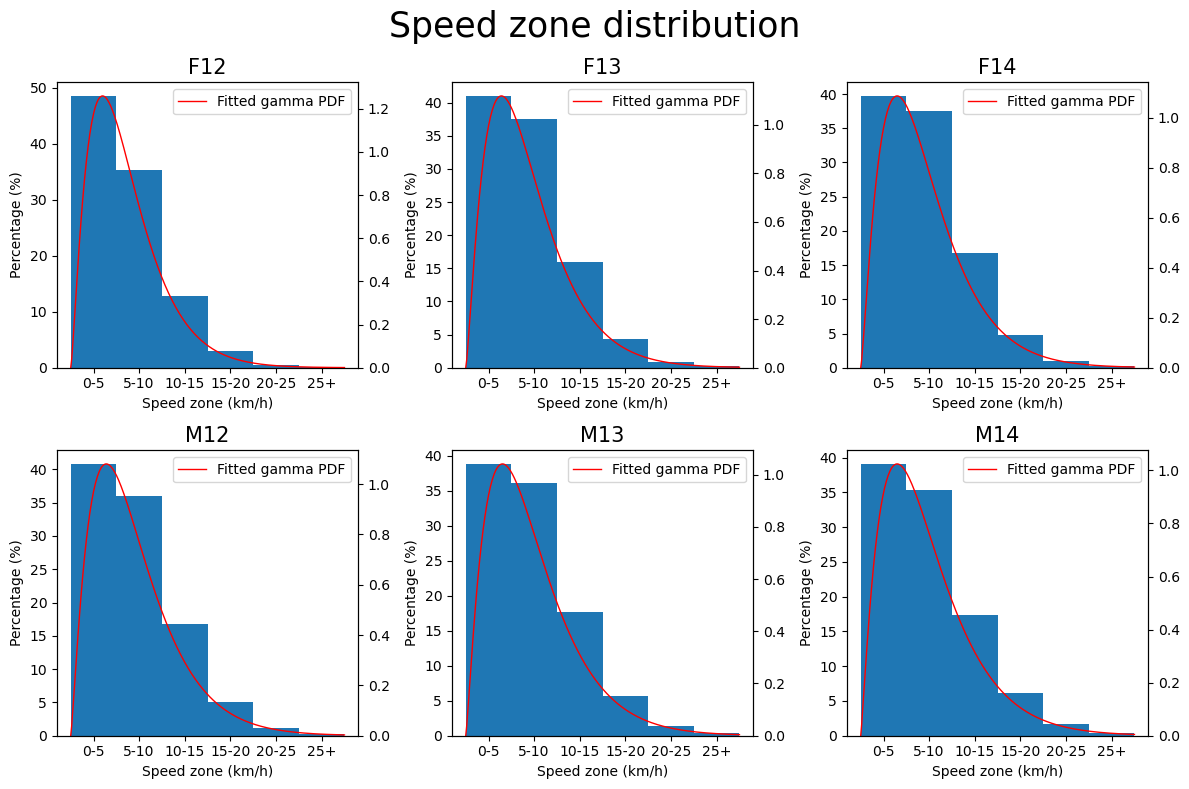

In [58]:
# plot tempo in a line plot by age groups
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

df_grouped = df.groupby('age')

# Shortened labels for speed zones
zone_labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25+']
zone_midpoints = np.array([2.5, 7.5, 12.5, 17.5, 22.5, 27.5])

bar_width = 5 # width of the speed zone (0-5, 5-10, etc.)

# save gamma parameters
gamma_params_dict = {}

for i, (group_name, df_group) in enumerate(df_grouped):
    df_zones = df_group[zone_vars]

    speed_zone_columns = [col for col in df_zones.columns if ("first" not in col) and ("second" not in col)]

    # Sum the absolute time spent in each speed zone across all matches
    summed_zones = df_zones[speed_zone_columns].sum()

    # Normalize summed values to percentages
    total_time = summed_zones.sum()
    percentage_zones = (summed_zones / total_time) * 100

    # Reconstruct pseudo-speed data for fitting (or use real speeds if available)
    pseudo_speeds = np.repeat(zone_midpoints, (percentage_zones.values * 10).astype(int))  # scaling for sample size

    # Fit gamma distribution
    gamma_params = stats.gamma.fit(pseudo_speeds, floc=0)
    gamma_dist = stats.gamma(*gamma_params)

    # Save parameters for later use
    gamma_params_dict[group_name] = gamma_params

    # Generate x values for smooth curve
    x = np.linspace(0, 30, 300)
    pdf = gamma_dist.pdf(x)

    # Scale the PDF correctly
    bin_width = 5
    pdf_scaled = pdf * bin_width
    pdf_scaled = pdf_scaled / pdf_scaled.sum() * 100  # scale to percentage
    
    axes[i].bar(zone_midpoints, percentage_zones.values, width=bar_width)
    axes[i].set_title(group_name, fontsize=15)
    axes[i].set_xlabel('Speed zone (km/h)', fontsize=10)
    axes[i].set_ylabel('Percentage (%)', fontsize=10)
    axes[i].set_xticks(zone_midpoints)
    axes[i].set_xticklabels(zone_labels)

    # Twin y-axis for the gamma PDF
    ax2 = axes[i].twinx()
    ax2.plot(x, pdf_scaled, color='red', linewidth=1, label='Fitted gamma PDF')
    ax2.tick_params(axis='y')
    ax2.set_ylim(0)  # Adjust y-axis limits for the PDF

    ax2.legend(loc='upper right')

fig.suptitle('Speed zone distribution', fontsize=25)
plt.tight_layout()

#### Speed statistic distributions

Age group: F12
KS statistic: 0.0632313034343906, p-value: 0.20293470232305394
Domestic mean: 1.6936816230934368, International mean: 1.689921170668133
Age group: F13
KS statistic: 0.08993921053330148, p-value: 0.00281147140618695
Domestic mean: 1.9134895117136657, International mean: 1.8833581322788648
Age group: F14
KS statistic: 0.04011215016033443, p-value: 0.4670880479541431
Domestic mean: 1.9530441508177891, International mean: 1.9393245934054097
Age group: M12
KS statistic: 0.09139673274322457, p-value: 0.00035766180703365237
Domestic mean: 1.9829874354979926, International mean: 1.9269984372234776
Age group: M13
KS statistic: 0.03749467745369385, p-value: 0.5799051560696898
Domestic mean: 2.023291556077989, International mean: 2.0090477079153195
Age group: M14
KS statistic: 0.07985408279022177, p-value: 0.004452540745075736
Domestic mean: 2.0613270829304122, International mean: 2.029729256305389


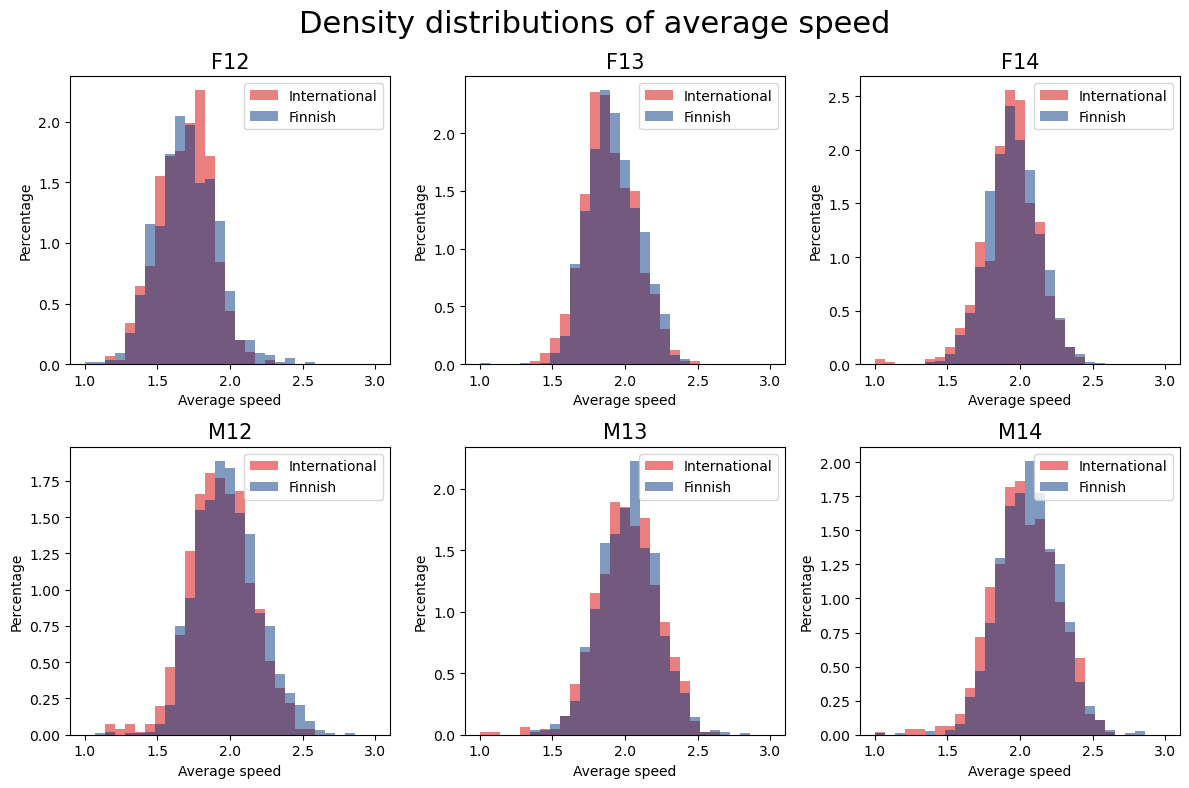

In [59]:
# create a distribution plot for the average speed
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Define colors
colors = ['#003580', '#d50000']

df_grouped = df.groupby('age')

for i, (group_name, df_group) in enumerate(df_grouped):
    avg_speed_dom = df_group.loc[df_group['team_int'] == 0, 'avg_speed']
    avg_speed_int = df_group.loc[df_group['team_int'] == 1, 'avg_speed']
    
    ax = axes[i]

    # Remove NaN values for KS test
    avg_speed_dom = avg_speed_dom.dropna()
    avg_speed_int = avg_speed_int.dropna()

    ks_stat, p = ks_2samp(avg_speed_dom, avg_speed_int)
    print(f"Age group: {group_name}")
    print(f"KS statistic: {ks_stat}, p-value: {p}")
    print(f"Domestic mean: {avg_speed_dom.mean()}, International mean: {avg_speed_int.mean()}")

    # Plot first histogram (overlap=True)

    ax.hist(avg_speed_int,  
        alpha=0.5, 
        label='International',
        bins=np.linspace(1.0, 3.0, 30),
        color=colors[1],
        density=True) 

    ax.hist(avg_speed_dom, 
        alpha=0.5, 
        label='Finnish',
        bins=np.linspace(1.0, 3.0, 30),
        color=colors[0],
        density=True) 

    ax.set_xlabel('Average speed', fontsize=10)
    ax.set_ylabel('Percentage', fontsize=10)
    ax.set_title(f'{group_name}', fontsize=15)
    ax.legend(loc='upper right')

plt.suptitle("Density distributions of average speed", fontsize=22)
plt.tight_layout()
plt.show()

Age group: F12
KS statistic: 0.057801056286656355, p-value: 0.29374721639252216
Domestic mean: 6.253563362609787, International mean: 6.276418604651162
Age group: F13
KS statistic: 0.0708529107270845, p-value: 0.03361088996252845
Domestic mean: 6.743741339491917, International mean: 6.791724137931034
Age group: F14
KS statistic: 0.04484887150300242, p-value: 0.32999927962967035
Domestic mean: 6.854626865671642, International mean: 6.79459842519685
Age group: M12
KS statistic: 0.1434904406066251, p-value: 1.2078439670589032e-09
Domestic mean: 6.732328080229227, International mean: 6.90394540942928
Age group: M13
KS statistic: 0.10928917394081329, p-value: 7.963188750204727e-05
Domestic mean: 7.118991071428572, International mean: 7.250178837555888
Age group: M14
KS statistic: 0.06344766480562908, p-value: 0.0419294075170117
Domestic mean: 7.350783582089553, International mean: 7.328658718330849


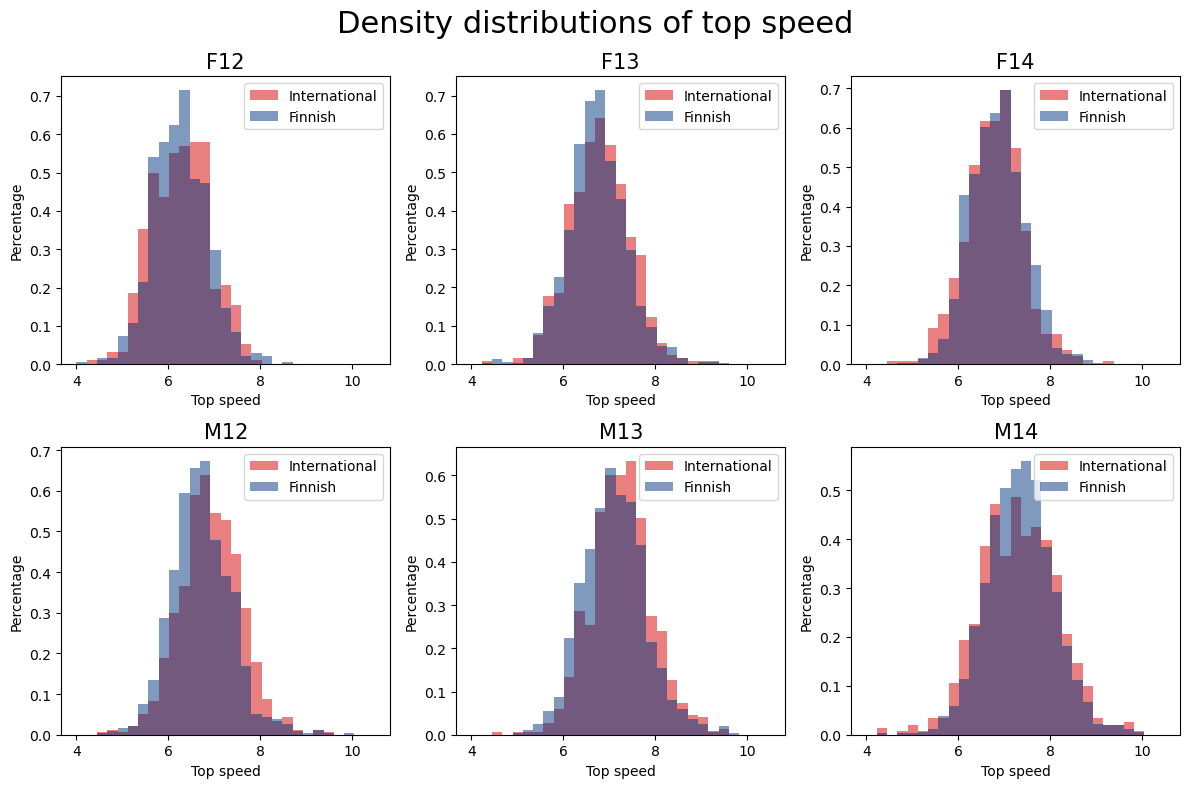

In [60]:
# create a distribution plot for the average speed
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Define colors
colors = ['#003580', '#d50000']

df_grouped = df.groupby('age')

for i, (group_name, df_group) in enumerate(df_grouped):
    top_speed_dom = df_group.loc[df_group['team_int'] == 0, 'top_speed']
    top_speed_int = df_group.loc[df_group['team_int'] == 1, 'top_speed']

    ax = axes[i]

    # Remove NaN values for KS test
    top_speed_dom = top_speed_dom.dropna()
    top_speed_int = top_speed_int.dropna()

    ks_stat, p = ks_2samp(top_speed_dom, top_speed_int)
    print(f"Age group: {group_name}")
    print(f"KS statistic: {ks_stat}, p-value: {p}")
    print(f"Domestic mean: {top_speed_dom.mean()}, International mean: {top_speed_int.mean()}")

    # Plot first histogram (overlap=True)

    ax.hist(top_speed_int,  
        alpha=0.5, 
        label='International',
        bins=np.linspace(4, 10.5, 30),
        color=colors[1],
        density=True)
    
    ax.hist(top_speed_dom, 
        alpha=0.5, 
        label='Finnish',
        bins=np.linspace(4, 10.5, 30),
        color=colors[0],
        density=True) 

    ax.set_xlabel('Top speed', fontsize=10)
    ax.set_ylabel('Percentage', fontsize=10)
    ax.set_title(f'{group_name}', fontsize=15)
    ax.legend(loc='upper right')

plt.suptitle("Density distributions of top speed", fontsize=22)
plt.tight_layout()
plt.show()

When analysed on a team level, the average speed of players is statistically significantly higher with the Finnish teams but the top speed is higher on the international teams.

#### Match wise difference
It was said to raise the intensity of the Finnish team as well, when the other team is international so we can anlyse the difference between these two types of matches.

Age group: F12
KS statistic: 0.05342343705347387, p-value: 0.36124271932112717
Age group: F13
KS statistic: 0.06322101682555287, p-value: 0.04739915216561221
Age group: F14
KS statistic: 0.04670352794346003, p-value: 0.21076588670320542
Age group: M12
KS statistic: 0.08101677468072185, p-value: 0.002323632145590933
Age group: M13
KS statistic: 0.04564320454669654, p-value: 0.3487043438549278
Age group: M14
KS statistic: 0.0544895051030233, p-value: 0.06449554557346578


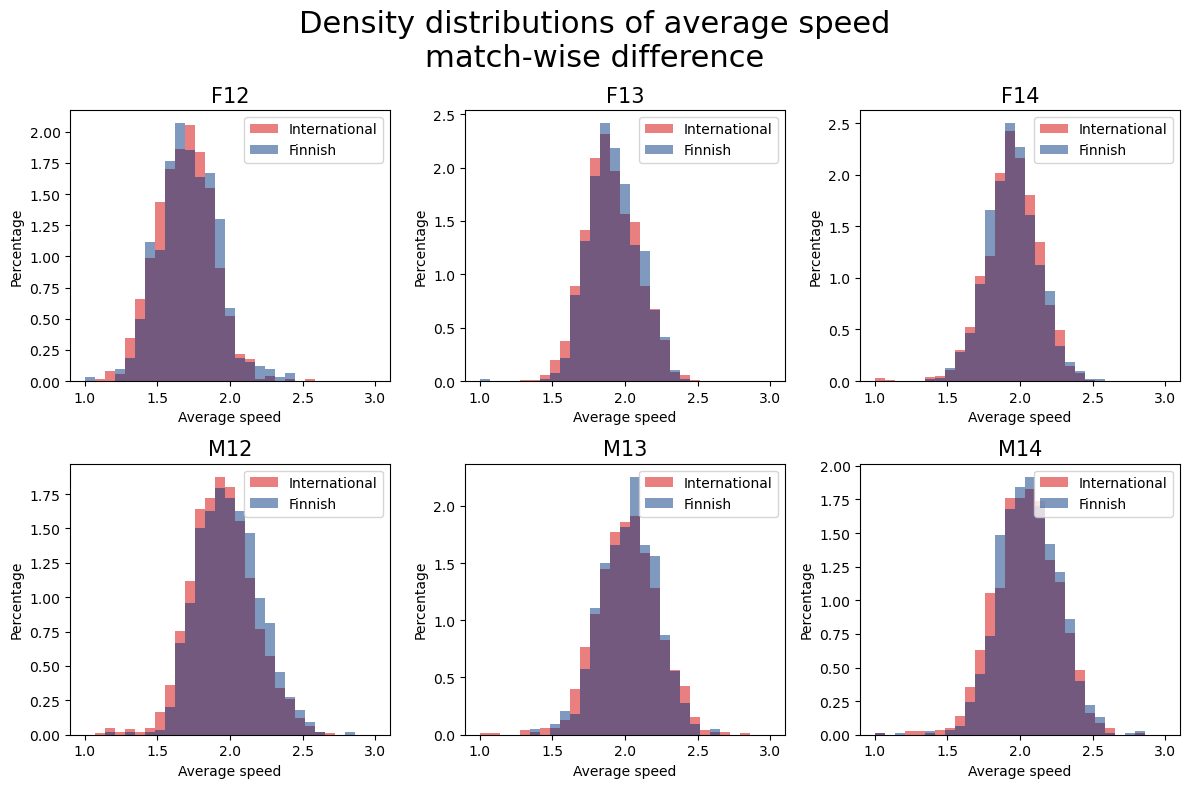

In [61]:
# create a distribution plot for the average speed
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Define colors
colors = ['#003580', '#d50000']

df_grouped = df.groupby('age')

for i, (group_name, df_group) in enumerate(df_grouped):
    avg_speed_dom = df_group.loc[df_group['int_level'] == 0, 'avg_speed']
    avg_speed_int = df_group.loc[df_group['int_level'] == 1, 'avg_speed']

    ax = axes[i]

    # Remove NaN values for KS test
    avg_speed_dom = avg_speed_dom.dropna()
    avg_speed_int = avg_speed_int.dropna()

    ks_stat, p = ks_2samp(avg_speed_dom, avg_speed_int)
    print(f"Age group: {group_name}")
    print(f"KS statistic: {ks_stat}, p-value: {p}")

    # Plot first histogram (overlap=True)

    ax.hist(avg_speed_int,  
        alpha=0.5, 
        label='International',
        bins=np.linspace(1.0, 3.0, 30),
        color=colors[1],
        density=True) 

    ax.hist(avg_speed_dom, 
        alpha=0.5, 
        label='Finnish',
        bins=np.linspace(1.0, 3.0, 30),
        color=colors[0],
        density=True) 

    ax.set_xlabel('Average speed', fontsize=10)
    ax.set_ylabel('Percentage', fontsize=10)
    ax.set_title(f'{group_name}', fontsize=15)
    ax.legend(loc='upper right')

plt.suptitle("Density distributions of average speed\nmatch-wise difference", fontsize=22)
plt.tight_layout()
plt.show()

Age group: F12
KS statistic: 0.04930489014406509, p-value: 0.4606107991926274
Age group: F13
KS statistic: 0.07974887441182105, p-value: 0.005269469320783887
Age group: F14
KS statistic: 0.02477155199520126, p-value: 0.904894221851905
Age group: M12
KS statistic: 0.11391274825098177, p-value: 3.1968197380372833e-06
Age group: M13
KS statistic: 0.11151975517787857, p-value: 6.891924632716638e-05
Age group: M14
KS statistic: 0.06978779125746197, p-value: 0.007273416851721738


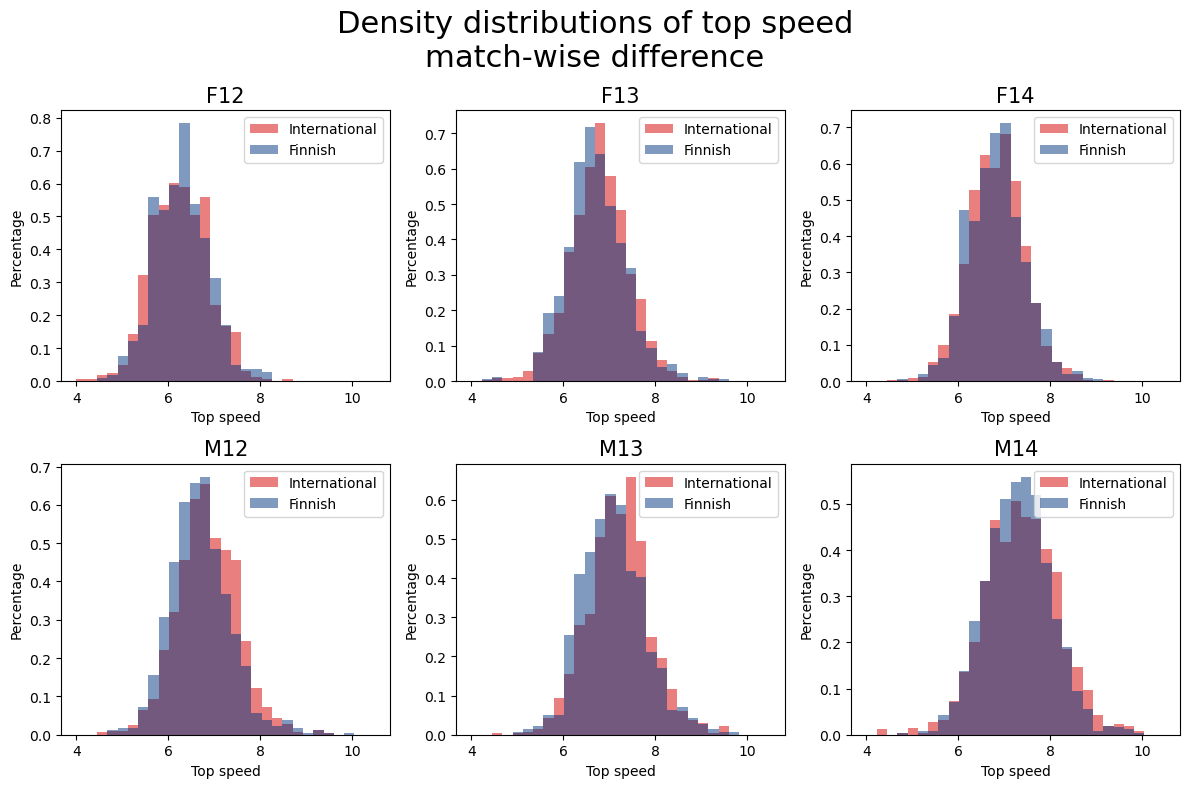

In [62]:
# create a distribution plot for the average speed
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Define colors
colors = ['#003580', '#d50000']

df_grouped = df.groupby('age')

for i, (group_name, df_group) in enumerate(df_grouped):
    top_speed_dom = df_group.loc[df_group['int_level'] == 0, 'top_speed']
    top_speed_int = df_group.loc[df_group['int_level'] == 1, 'top_speed']

    ax = axes[i]

    # Remove NaN values for KS test
    top_speed_dom = top_speed_dom.dropna()
    top_speed_int = top_speed_int.dropna()

    ks_stat, p = ks_2samp(top_speed_dom, top_speed_int)
    print(f"Age group: {group_name}")
    print(f"KS statistic: {ks_stat}, p-value: {p}")

    # Plot first histogram (overlap=True)

    ax.hist(top_speed_int,  
        alpha=0.5, 
        label='International',
        bins=np.linspace(4, 10.5, 30),
        color=colors[1],
        density=True)

    ax.hist(top_speed_dom, 
        alpha=0.5, 
        label='Finnish',
        bins=np.linspace(4, 10.5, 30),
        color=colors[0],
        density=True) 

    ax.set_xlabel('Top speed', fontsize=10)
    ax.set_ylabel('Percentage', fontsize=10)
    ax.set_title(f'{group_name}', fontsize=15)
    ax.legend(loc='upper right')

plt.suptitle("Density distributions of top speed\nmatch-wise difference", fontsize=22)
plt.tight_layout()
plt.show()

#### Calculate intensity from load metric formula

We can calculate the intensity of a session from this formula from an academic article:

Intensity = (TD_min/TD_min_max + AcDe_min/AcDe_min_max + HID_min/HID_min_max)/3

TD_min = total distance per minute
AcDe_min = number of ac/decelerations per minute
HID_min = distance in high intensity speeds per minute, >15km/h

The max values are reference values that can be individual or generic, since the player IDs can change accross matches, we must use the generic reference value. We will take this as the maximum value of the age group.

#### Intensity calculations

Calculate distance in eacg speed zone by avg speed of zone times time. Calculate intensity.

In [63]:
# calculate distance ran in speed zones based on the time and an average speed from the zone iteratively
zone_ends = ['0_5', '5_10', '10_15', '15_20', '20_25', '25_plus']
zone_midpoints = np.array([0, 5, 10, 15, 20, 25])
for zone_end, zone_mid in zip(zone_ends, zone_midpoints):
    df[f'distance_in_speed_zone_{zone_end}'] = df[f'time_in_speed_zone_{zone_end}'] * zone_mid / 3.6  # Convert to m/s
    zone_vars.append(f'distance_in_speed_zone_{zone_end}')

# combine distances from 15 km/h and above
df['distance_in_HI_zones'] = df['distance_in_speed_zone_15_20'] + df['distance_in_speed_zone_20_25'] + df['distance_in_speed_zone_25_plus']

In [64]:
# compute intensity for each player

# needed variables
intensity_vars = ['distance', 'accelerations', 'decelerations', 'distance_in_HI_zones', 'onfield_time']
intensity_df = df[info_vars + intensity_vars].copy()

# combine accelerations and decelerations
intensity_df['ac_de'] = intensity_df['accelerations'] + intensity_df['decelerations']

# create per minute columns
intensity_df['distance_min'] = intensity_df['distance'] / (intensity_df['onfield_time'] / 60)
intensity_df['ac_de_min'] = intensity_df['ac_de'] / (intensity_df['onfield_time'] / 60)
intensity_df['distance_in_HI_zones_min'] = intensity_df['distance_in_HI_zones'] / (intensity_df['onfield_time'] / 60)

# intensity_df = intensity_df.drop(columns=['tournament_id', 'match_id', 'player_id', 'team', 'ac_de', *intensity_vars])

df_grouped = intensity_df.groupby('age')

max_dict = {}

for i, (group_name, df_group) in enumerate(df_grouped):
    max_dict[group_name] = [df_group['distance_min'].quantile(0.99), df_group['ac_de_min'].quantile(0.99), df_group['distance_in_HI_zones_min'].quantile(0.99)]

# Compute intensity for each row
intensity_df['intensity'] = intensity_df.apply(
    lambda row: (
        row['distance_min'] / max_dict[row['age']][0] +
        row['ac_de_min'] / max_dict[row['age']][1] +
        row['distance_in_HI_zones_min'] / max_dict[row['age']][2]
    ) / 3 * 100,  # average and normalize to percentage
    axis=1
)

Age group: F12
KS statistic: 0.060929432013769366, p-value: 0.6493087664852842
Domestic mean: 52.67208270279135, International mean: 51.575866084242996
Age group: F13
KS statistic: 0.06817493946731235, p-value: 0.08632043309341836
Domestic mean: 60.42185967324311, International mean: 59.47511531263709
Age group: F14
KS statistic: 0.07286460699681963, p-value: 0.04817166758738207
Domestic mean: 60.33874818627167, International mean: 59.595255678203365
Age group: M12
KS statistic: 0.04235815110931759, p-value: 0.3548184740082455
Domestic mean: 56.56956391013242, International mean: 55.962609066369915
Age group: M13
KS statistic: 0.05074203667953668, p-value: 0.24940115179312672
Domestic mean: 60.65431142555565, International mean: 59.98570756475802
Age group: M14
KS statistic: 0.09096565765690898, p-value: 0.001119169762863868
Domestic mean: 60.783568033992324, International mean: 58.95158629151786


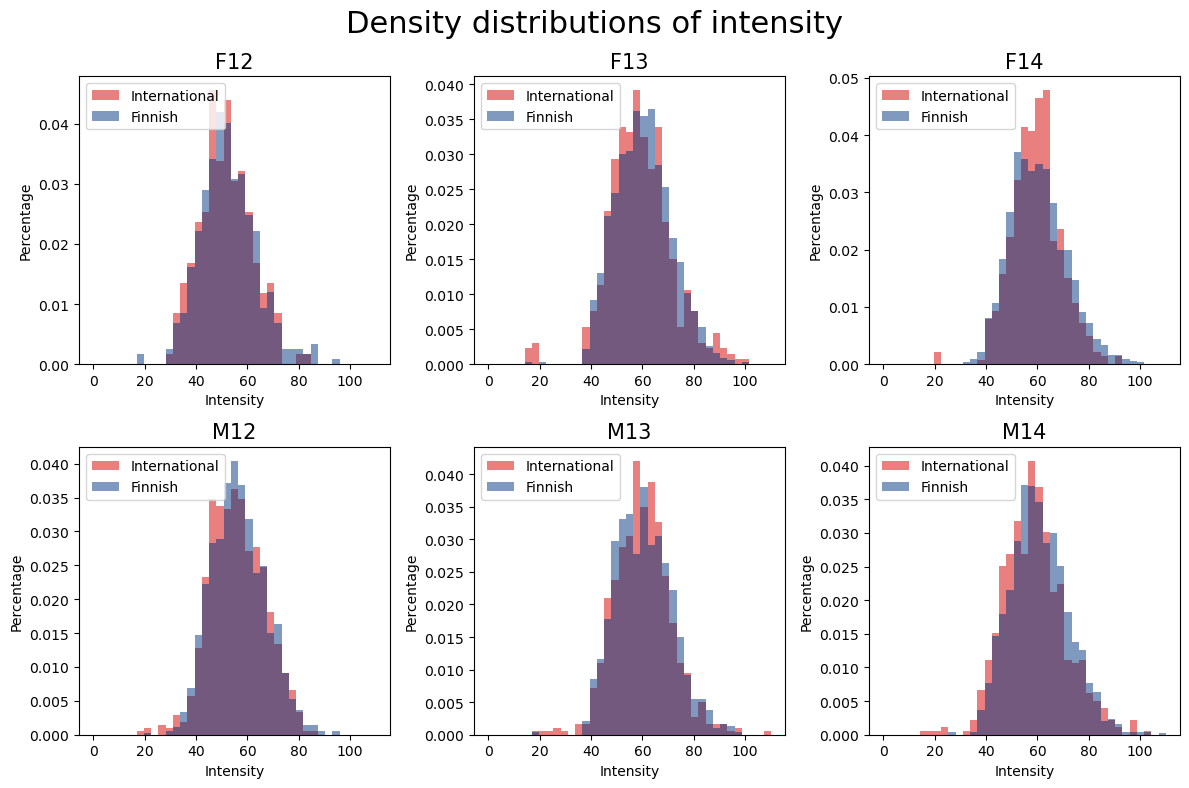

In [65]:
# create a distribution plot for the average speed
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Define colors
colors = ['#003580', '#d50000']

df_grouped = intensity_df.groupby('age')

for i, (group_name, df_group) in enumerate(df_grouped):
    intensity_dom = df_group.loc[df_group['team_int'] == 0, 'intensity']
    intensity_int = df_group.loc[df_group['team_int'] == 1, 'intensity']

    ax = axes[i]

    # Remove NaN values for KS test
    intensity_dom = intensity_dom.dropna()
    intensity_int = intensity_int.dropna()

    ks_stat, p = ks_2samp(intensity_dom, intensity_int)
    print(f"Age group: {group_name}")
    print(f"KS statistic: {ks_stat}, p-value: {p}")
    print(f"Domestic mean: {intensity_dom.mean()}, International mean: {intensity_int.mean()}")

    # Plot first histogram (overlap=True)

    ax.hist(intensity_int,  
        alpha=0.5, 
        label='International',
        bins=np.linspace(0, 110, 40),
        color=colors[1],
        density=True)

    ax.hist(intensity_dom, 
        alpha=0.5, 
        label='Finnish',
        bins=np.linspace(0, 110, 40),
        color=colors[0],
        density=True) 

    ax.set_xlabel('Intensity', fontsize=10)
    ax.set_ylabel('Percentage', fontsize=10)
    ax.set_title(f'{group_name}', fontsize=15)
    ax.legend(loc='upper left')

plt.suptitle("Density distributions of intensity", fontsize=22)
plt.tight_layout()
plt.show()

In [66]:
intensity_df[intensity_df['intensity'] < 20]

,tournament_id,match_id,player_id,team,age,int_level,team_int,distance,accelerations,decelerations,distance_in_HI_zones,onfield_time,ac_de,distance_min,ac_de_min,distance_in_HI_zones_min,intensity
568,58,1283,7465,Away,M12,1,1,1094.11,3.0,3.0,14.527778,945.12,6.0,69.458481,0.380904,0.922281,18.284219
1453,59,1312,7607,Home,F13,1,1,2309.23,21.0,18.0,31.638889,2435.22,39.0,56.895804,0.960899,0.779533,19.471581
1472,59,1312,7583,Away,F13,1,1,959.79,4.0,5.0,25.750000,1134.24,9.0,50.771794,0.476090,1.362146,16.191231
1550,59,1309,7583,Home,F13,1,1,1978.30,11.0,7.0,46.111111,2484.24,18.0,47.780408,0.434741,1.113687,14.977858
1657,59,1306,7583,Away,F13,1,1,2221.60,21.0,14.0,40.222222,2552.84,35.0,52.214788,0.822613,0.945352,17.829685
1808,59,1301,7607,Away,F13,1,1,2310.18,13.0,10.0,25.083333,2472.60,23.0,56.058724,0.558117,0.608671,17.022625
1852,59,1300,7670,Away,F13,0,0,2547.48,13.0,19.0,29.833333,2457.10,32.0,62.206992,0.781409,0.728501,19.776164
1890,59,1298,7583,Home,F13,1,1,2260.10,14.0,14.0,54.444444,2491.64,28.0,54.424395,0.674255,1.311051,18.021654
1953,59,1296,7663,Home,F13,1,0,2095.21,12.0,10.0,24.694444,2476.26,22.0,50.767125,0.533062,0.598349,15.610307
2027,59,1294,7583,Away,F13,1,1,1159.98,4.0,6.0,13.861111,1232.30,10.0,56.478780,0.486894,0.674890,16.836093
